In [15]:
# Code for Research Assignment of ASTR400B
# Binh Nguyen
# with code from G. Besla, R. Hoffman and E. Patel
# special thanks to Hayden Foote for suggestions on how to plot polar coordinates

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [29]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992

import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

# Info about **kwargs, *args 
#https://book.pythontips.com/en/latest/args_and_kwargs.html

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        i.e. unknown number of keywords 
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
             colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))  
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T  # transpose of distribution fxn
    fmt = {}
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.50))
    #brentq is root finding method
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.71))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.82))
    
    # You might need to add a few levels
    # I added a few between 1 and 2 sigma to better highlight the spiral arm
    one_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.56))
    one_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.62))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, one_sigma1, one_sigma2, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.50', '0.56','0.62','0.71', '0.82'][::-1]

    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [17]:
def COMCorrections(filename):
    
    """
    a function that takes a filename containing M33 at a certain snapshot, then corrects the 3D positions 
    and velocities by the center of mass to return the COM-corrected positions and velocities.    
    
    PARAMETERS:
    ------
        filename: 'string'
            the name of the file containing all the data in each snapshot
    RETURNS:
    ------
        r: 'array of floats'
            3D positions (x, y, z) of all the particles in the disk
        v: 'array of floats'
            3D velocities (vx, vy, vz) of all the particles in the disk
    """
    
    # Note down the address of the file
    link = "D:/Academics/2022-2023/Spring 2023 - ASTR 400B (Gurtina Besla)/VLowRes/" + filename
    
    # Create a COM of object for M31 Disk Using Code from Assignment 4
    COMD = CenterOfMass(link, 2)
    
    # Compute COM of M31 using disk particles
    COMP = COMD.COM_P(0.1)
    COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])

    # Determine positions of disk particles relative to COM 
    xD = COMD.x - COMP[0].value 
    yD = COMD.y - COMP[1].value 
    zD = COMD.z - COMP[2].value 

    # total magnitude
    rtot = np.sqrt(xD**2 + yD**2 + zD**2)

    # Determine velocities of disk particles relatiev to COM motion
    vxD = COMD.vx - COMV[0].value 
    vyD = COMD.vy - COMV[1].value 
    vzD = COMD.vz - COMV[2].value 

    # total velocity 
    vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

    # Vectors for r and v 
    r = np.array([xD,yD,zD]).T # transposed for the Rotate Function later
    v = np.array([vxD,vyD,vzD]).T
    
    return r, v

In [18]:
def GalaxySeparation(file_idx):
    
    """
    a function that takes a filename containing M33 at a certain snapshot, then corrects the 3D positions 
    and velocities by the center of mass to return the COM-corrected positions and velocities.    
    
    PARAMETERS:
    ------
        file_idx: 'array of strings'
            a NumPy array of all the indexes of the snapshot files we're interested in.
            for example: if we want to look at data files M33_030, M33_040 and M33_050, then
            file_idx = ['030', '040', '050'] where all the elements are strings.
    RETURNS:
    ------
        all_separations: 'array of floats'
            separation between M31 and M33 across all the relevant snapshots
    """
    
    ### Create an array of zeroes that's the same size as the array of relevant indexes. 
    ### This is where the galactic separation will be stored.
    all_separations = np.zeros(np.size(file_idx))*u.kpc
    
    ### Now, we go over every single index in file_idx and calculate the separation at that snapshot.
    i = 0 
    
    for idx in file_idx:
        
        # Note down the address of the file that contains M33 data
        M33_link = "D:/Academics/2022-2023/Spring 2023 - ASTR 400B (Gurtina Besla)/VLowRes/M33_" + str(idx) + ".txt"

        # Create a COM of M33 using code from Assignment 4
        M33_COMD = CenterOfMass(M33_link, 2)
        M33_COM_p = M33_COMD.COM_P(0.1)

        # Note down the address of the file that contains M31 (Andromeda) data
        M31_link = "D:/Academics/2022-2023/Spring 2023 - ASTR 400B (Gurtina Besla)/VLowRes/M31_" + str(idx) + ".txt"

        # Create a COM of M31 (Andromeda) using code from Assignment 4
        M31_COMD = CenterOfMass(M31_link, 2)
        M31_COM_p = M31_COMD.COM_P(0.1)
        
        # Calculate the separation between M33 and M31
        separation = np.sqrt(np.sum((M31_COM_p - M33_COM_p)**2))
        
        # Add the separation we just calculated into the all_separations array
        all_separations[i] = separation
        i += 1
        
    return all_separations

In [19]:
def RotateFrame(posI,velI):
    
    """
    a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))

    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [20]:
def IntegerIntoString(int_array):

    """
    for convenience, this function will turn an array of generated integers by np.arange 
    into an array of strings that resemble the data filenames. for example: 0 becomes '000'
    and '20' becomes '020'.    
    PARAMETERS
    ----------
        int_array: 'array of int'
            array of integers generated by np.arange
             
    RETURNS
    -------
        string_array: `array of strings'
            array of strings made out of int_array 
    """
    
    string_array = []
    for number in int_array:
        if len(str(number)) == 1:
            number = '00' + str(number)
            string_array.append(number)
        elif len(str(number)) == 2:
            number = '0' + str(number)
            string_array.append(number)
        else:
            number = str(number)
            string_array.append(number)
    
    return np.array(string_array, dtype='object')

In [21]:
def FindTime(int_array):
    
    """
    This function will look at each .txt data file whose index is included in an integer array and then
    locate the time information inside it. The files are structured such that the time is stored in 
    a line that starts with "Time", so there will be a for-loop that looks for that line and reads it 
    as a string to get to the time information. Then, the function will convert the time recorded 
    into units of years (the time is originally stored in Myrs).
    
    PARAMETERS
    ----------
        int_array: 'array of int'
            array of integers generated by np.arange
             
    RETURNS
    -------
        times: `array of floats'
            array of floats that correspond to the times at which the data files were taken
    """
    
    times = []
    
    for idx in int_array:
        filename = "D:/Academics/2022-2023/Spring 2023 - ASTR 400B (Gurtina Besla)/VLowRes/M33_" + str(idx) + ".txt"
        with open(filename) as f:
            for line in f:
                if line.startswith('Time'):
                    times.append(float(line[10:]) * 1e6)
    
    times = np.array(times, dtype=object)
    return times

## Part 1: Find the pericenter and apocenter snapshots.

We know from previous studies that satellite galaxies can exhibit spiral arms at pericenter and/or apocenter. Therefore, in order to study the spiral arms of M33 in the simulation, we have to narrow down the number of snapshots where the spiral arms develop, firstly by narrowing down the number of snapshots where M33 is near or at either pericenter or apocenter.

In [22]:
### First, we define the snapshots we want to look at. Using np.arange, we can generate a number of indices
### that match the filenames we want to study, then using IntegerIntoString, we will turn those indices into
### strings so that GalaxySeparation can read the corresponding filenames and find the M31-M33 separation at
### all those snapshots.

# This calls IntegerIntoString and returns a NumPy array of string-ified indices.
idx = IntegerIntoString(np.arange(0, 810, 10))

# This calls GalaxySeparation to find the separations at the snapshots that we identified using the indices.
separations = GalaxySeparation(idx)
times = FindTime(idx)

In [23]:
### Next we find the pericenters and apocenters along M33's orbit around M31. Because I don't know 
### any other way, what I did was to look at the plot of M33's separation over time (which is plotted 
### in the next cell) and then manually limit the time ranges to find the maximum and minimum in each range.

peri1 = min(separations[times < 0.4e10])
time_peri1 = times[separations == peri1][0]
idx_peri1 = idx[separations == peri1][0]

apo1 = max(separations[times < 0.4e10])
time_apo1 = times[separations == apo1][0]
idx_apo1 = idx[separations == apo1][0]

peri2 = min(separations[(0.4e10 < times) & (times < 0.62e10)])
time_peri2 = times[separations == peri2][0]
idx_peri2 = idx[separations == peri2][0]

apo2 = max(separations[(0.4e10 < times) & (times < 0.62e10)])
time_apo2 = times[separations == apo2][0]
idx_apo2 = idx[separations == apo2][0]

peri3 = min(separations[(0.62e10 < times) & (times < 0.8e10)])
time_peri3 = times[separations == peri3][0]
idx_peri3 = idx[separations == peri3][0]

apo3 = max(separations[(0.62e10 < times) & (times < 0.8e10)])
time_apo3 = times[separations == apo3][0]
idx_apo3 = idx[separations == apo3][0]

peri4 = min(separations[(0.8e10 < times) & (times < 0.9e10)])
time_peri4 = times[separations == peri4][0]
idx_peri4 = idx[separations == peri4][0]
                       
apo4 = max(separations[(0.8e10 < times) & (times < 0.9e10)])
time_apo4 = times[separations == apo4][0]
idx_apo4 = idx[separations == apo4][0]

peri5 = min(separations[(0.9e10 < times) & (times < 1e10)])
time_peri5 = times[separations == peri5][0]
idx_peri5 = idx[separations == peri5][0]

apo5 = max(separations[(0.96e10 < times) & (times < 1.05e10)])
time_apo5 = times[separations == apo5][0]
idx_apo5 = idx[separations == apo5][0]

print('pericenters:', peri1, peri2, peri3, peri4, peri5)
print('apocenters:', apo1, apo2, apo3, apo4, apo5)
print('peri indices:', idx_peri1, idx_peri2, idx_peri3, idx_peri4, idx_peri5)
print('apo indices:', idx_apo1, idx_apo2, idx_apo3, idx_apo4, idx_apo5)

pericenters: 80.81867482209786 kpc 55.85218348462305 kpc 47.67103103563 kpc 42.925854679901256 kpc 36.50146709380323 kpc
apocenters: 218.61180228889748 kpc 164.32264025386155 kpc 108.2088850326072 kpc 88.73451864973406 kpc 76.61384927022007 kpc
peri indices: 060 300 470 580 670
apo indices: 190 380 530 620 700


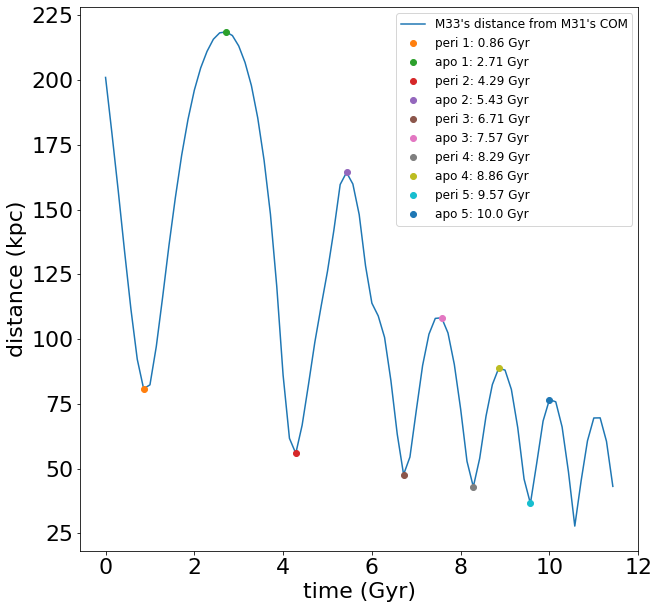

In [24]:
### Now, we plot M33's separation from M31 as a function of time

fig, ax= plt.subplots(figsize=(10, 10))

# This plots M33's separation from M31 as a function of time
plt.plot(times/1e9, separations, label="M33's distance from M31's COM")

# These mark the apocenter, the pericenter and the four in-between points that we arbitrarily chose
plt.plot(time_peri1/1e9, peri1, 'o', label='peri 1: ' + str(np.round(time_peri1/1e9, 2)) + " Gyr")
plt.plot(time_apo1/1e9, apo1, 'o', label='apo 1: ' + str(np.round(time_apo1/1e9, 2)) + " Gyr")
plt.plot(time_peri2/1e9, peri2, 'o', label='peri 2: ' + str(np.round(time_peri2/1e9, 2)) + " Gyr")
plt.plot(time_apo2/1e9, apo2, 'o', label='apo 2: ' + str(np.round(time_apo2/1e9, 2)) + " Gyr")
plt.plot(time_peri3/1e9, peri3, 'o', label='peri 3: ' + str(np.round(time_peri3/1e9, 2)) + " Gyr")
plt.plot(time_apo3/1e9, apo3, 'o', label='apo 3: ' + str(np.round(time_apo3/1e9, 2)) + " Gyr")
plt.plot(time_peri4/1e9, peri4, 'o', label='peri 4: ' + str(np.round(time_peri4/1e9, 2)) + " Gyr")
plt.plot(time_apo4/1e9, apo4, 'o', label='apo 4: ' + str(np.round(time_apo4/1e9, 2)) + " Gyr")
plt.plot(time_peri5/1e9, peri5, 'o', label='peri 5: ' + str(np.round(time_peri5/1e9, 2)) + " Gyr")
plt.plot(time_apo5/1e9, apo5, 'o', label='apo 5: ' + str(np.round(time_apo5/1e9, 2)) + " Gyr")

# Add axis labels
plt.xlabel('time (Gyr)', fontsize=22)
plt.ylabel('distance (kpc)', fontsize=22)

# Legend
plt.legend(fontsize=12)

# Save plot
plt.savefig('M33_distance.png')

## Part 2: Plot the snapshots in cylindrical coordinates.

In this part, we will plot the pericenter & apocenter snapshots to see if there are any spiral arm features on M33.

In [25]:
### Here, we'll put all the distances, snapshot times and indices into NumPy arrays to better plot things.

sep_to_plot = np.array([peri1, apo1, peri2, apo2, peri3, apo3, peri4, apo4, peri5, apo5], dtype=object)
time_to_plot = np.array([time_peri1, time_apo1, time_peri2, time_apo2, time_peri3, time_apo3, \
                         time_peri4, time_apo4, time_peri5, time_apo5], dtype=object)
idx_to_plot = np.array([idx_peri1, idx_apo1, idx_peri2, idx_apo2, idx_peri3, idx_apo3, \
                        idx_peri4, idx_apo4, idx_peri5, idx_apo5], dtype=object)

# print(sep_to_plot)
# print(time_to_plot)
# print(idx_to_plot)

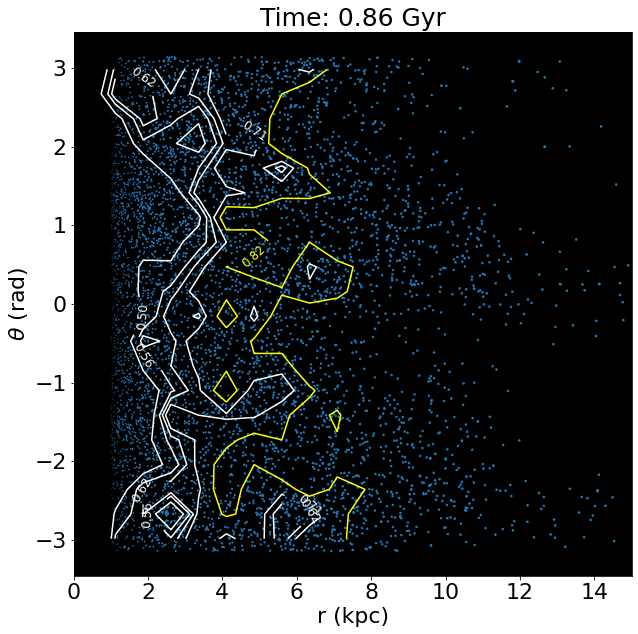

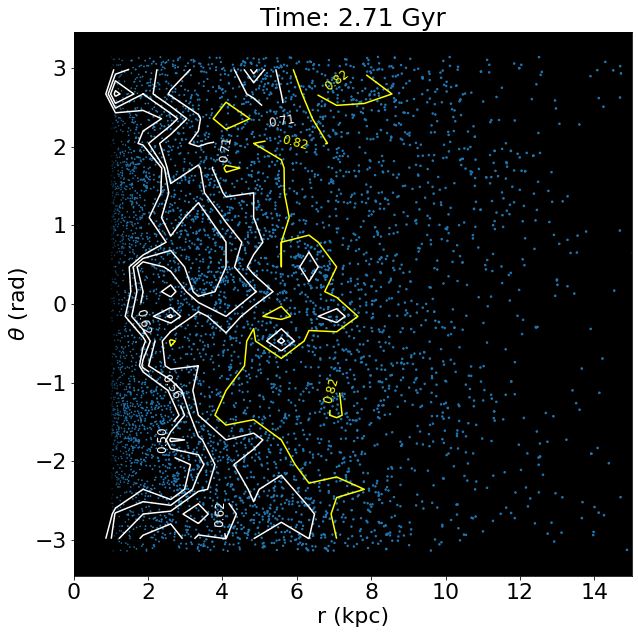

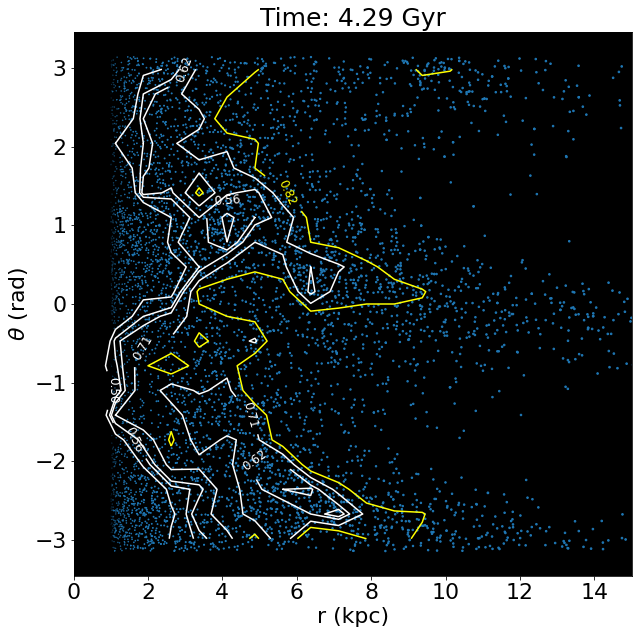

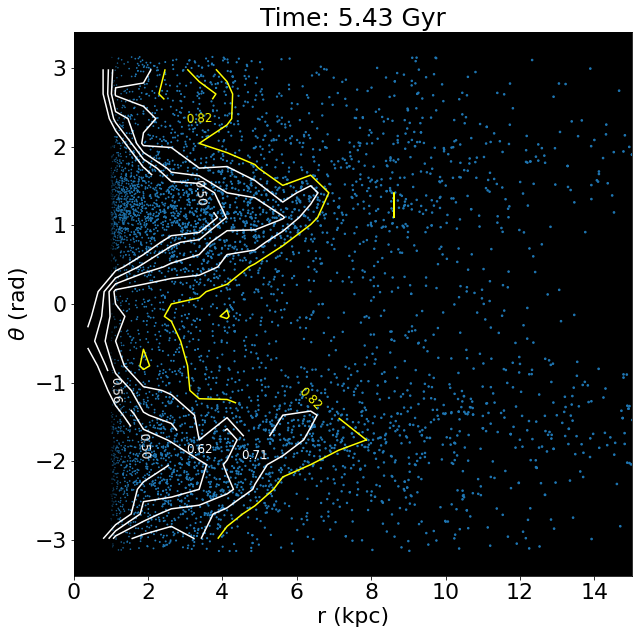

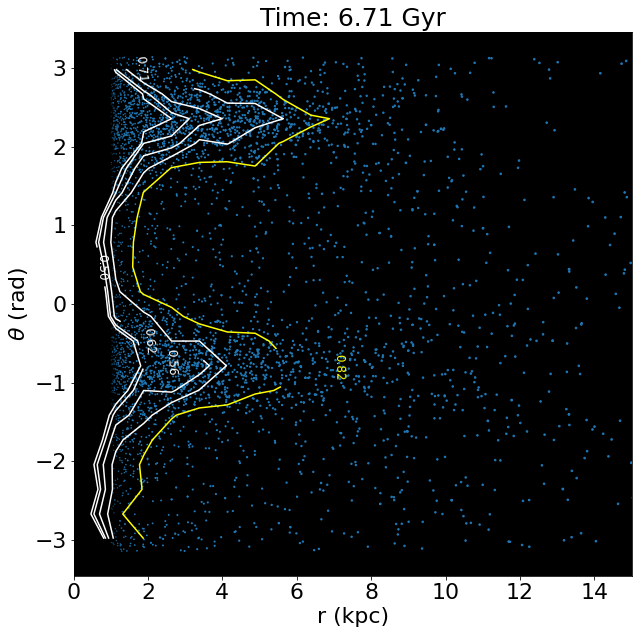

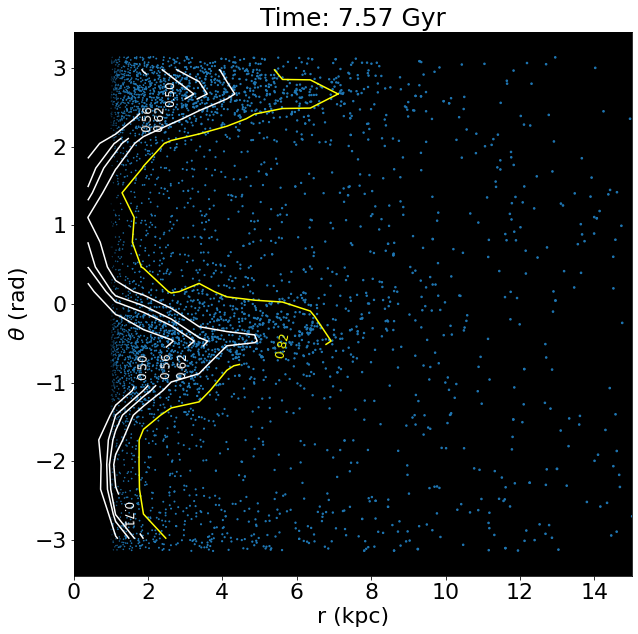

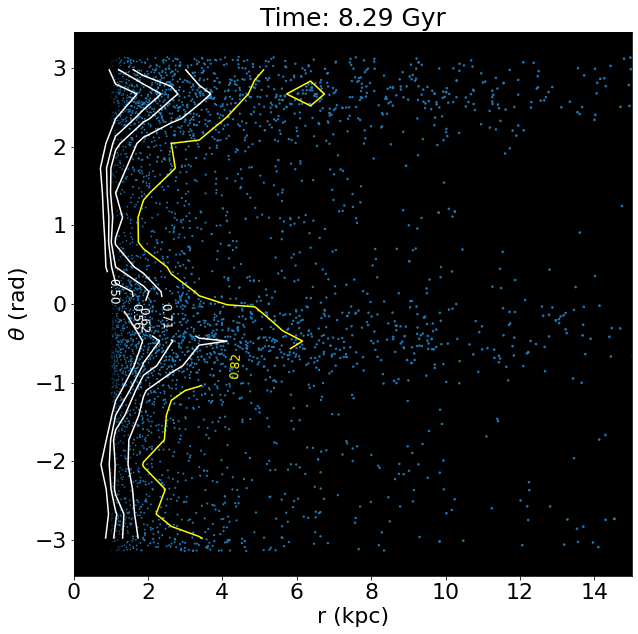

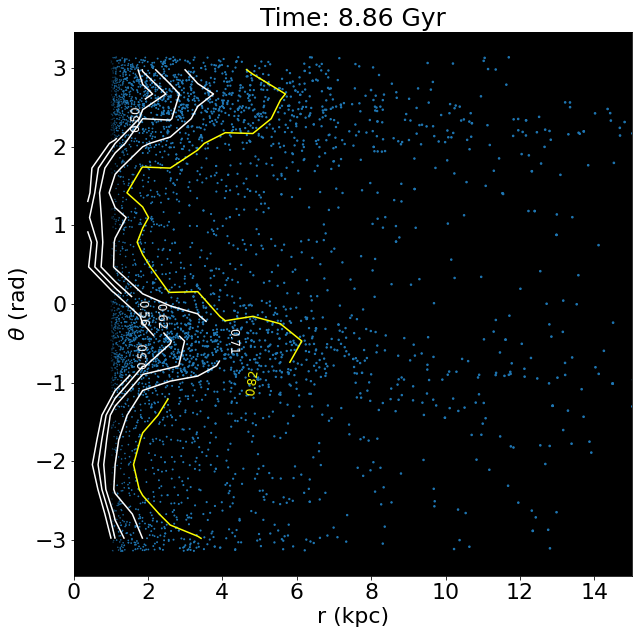

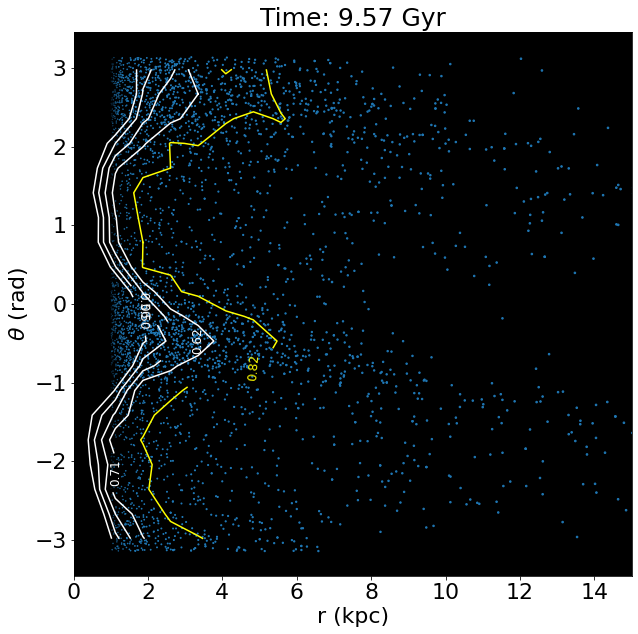

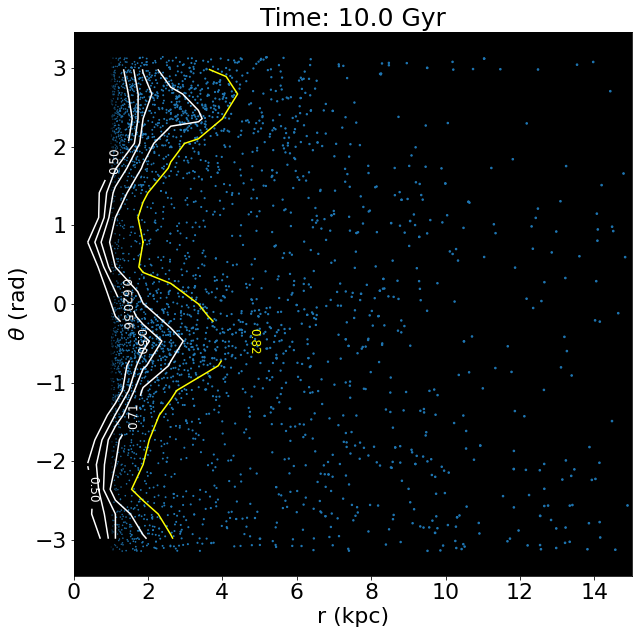

In [30]:
### Here we loop over all the indices from idx_to_plot to locate the data files we're interested in,
### which allows us to plot the stellar particle distribution in these data files.

# This is the for-loop that plots everything. It goes through idx_to_plot, the NumPy array that stores the index
# associated with all the snapshots of pericenters and apocenters that we care about. For example, if the data file
# is named 'M33_400.txt', then the index would be 400.
for index in idx_to_plot:
    
    # Because the data files are named like 'M33_090.txt' but the index that's returned is an integer (i.e. 
    # displayed as 90), we need these small if statements to ensure that even if the index that's read in
    # is 90, it still becomes a '090' string.
    if len(str(index)) == 1: 
        index = '00' + str(index) # so if the index read in is 9, it becomes a string '009'
    elif len(str(index)) == 2:
        index = '0' + str(index) # so if the index read in is 90, it becomes a string '090'
    
    # After fixing the indices, we create a file name to open.
    filename = "M33_" + str(index) + ".txt"
    
    # Correct for the center of mass
    r, v = COMCorrections(filename)

    # Compute the rotated velocity vectors
    rn, vn = RotateFrame(r,v)

    # Using cylindrical coordinates, you can find higher density regions in the R vs theta plots
    # to convert into cylindrical coordinates, remember: r = sqrt(x^2 + y^2) and theta = arcsin(y/r)
    r = np.sqrt(rn[:,0]**2 + rn[:,1]**2)
    theta = np.arctan2(rn[:,1], rn[:,0]) # arctan2 makes sign of quadrant correct

    ### Now, we plot the rotated M33 Disk - FACE ON, CYLINDRICAL COORDINATES

    # This creates a plotting space 
    fig, ax= plt.subplots(figsize=(10, 10))

    # Plot the particle density for M33 
    # Note: can modify bin number (bin = 100 smoothest)
    plt.scatter(r, theta, s=0.5*np.log(r**2))

    # Add axis labels
    plt.xlabel('r (kpc)', fontsize=22)
    plt.ylabel(r'${\theta}$ (rad)', fontsize=22)
    
    # This finds the time that corresponds to each data file, then converts said time into Gyr
    snapshot_time = time_to_plot[idx_to_plot == index][0] / 1e9 # this finds the time that corresponds to each data file
    
    # Add title indicating time of snapshot
    plt.title("Time: " + str(np.round(snapshot_time, 2)) + " Gyr", fontsize=25)
        
    # Adjust tick label font size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size

    # Make the contour plot
    # x pos, y pos, contour res, contour res, axis, colors for contours.
    # NOTE: the condition [r < 5] is so that the code only cares about the inner regions 
    # and ignores the outskirts, which might include a density of particles inside a tidal tail
    density_contour(r[r<15], theta[r<15], 20, 20, ax=ax, colors=['yellow', 'white', 'white', 'white', 'white'])

    plt.xlim(0,15)
    ax.set_facecolor('xkcd:black')

    # save plot
    plt.savefig('M33_' + str(index) + '_particles.png')

In [27]:
### Here, we create an example of a density contour plot for Figure 2 of the final report.

# create an instance of COMCorrections for a certain snapshot
r, v = COMCorrections("M33_190.txt")

# compute the rotated velocity vectors
rn, vn = RotateFrame(r,v)

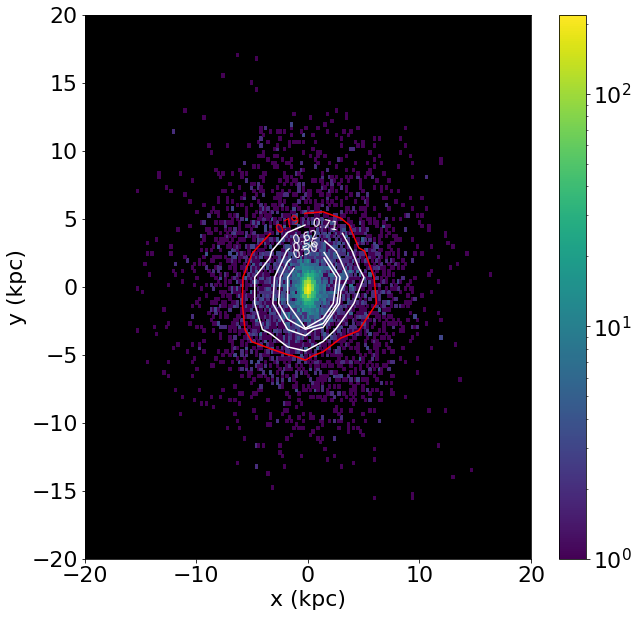

In [28]:
# Rotated M33 Disk - FACE ON

# M33 Disk Density 
fig, ax= plt.subplots(figsize=(10, 10))

# plot the particle density for M33 
# can modify bin number (bin =100 smoothest)
plt.hist2d(rn[:,0], rn[:,1], bins=150, norm=LogNorm(), cmap='viridis')
plt.colorbar()

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-20,20)
plt.xlim(-20,20)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
density_contour(rn[:,0], rn[:,1], 20, 20, ax=ax, 
                colors=['red','white', 'white', 'white', 'white'])

ax.set_facecolor('xkcd:black')

# save plot
plt.savefig('M33densitycontour.png')